# Cleaning and EDA of Housing Data

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
import missingno as msno
pd.set_option('display.max_rows', 500)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer


%matplotlib inline

In [2]:
df=pd.read_csv('../datasets/train.csv')
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


## Clean up column names to snake case

In [3]:
def snake_split (df):
    """
    df = pandas dataframe
    
    -------------
    This will convert columns names to snake case 
    and split numeric and categorical column titles
    
    """
    df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('qual','quality')



## Handling different data types
- I seperated variables because I will treat each subset of features with different methodologies.

In [4]:
snake_split(df)
category_cols = df.select_dtypes(include=object).columns
num_cols = df.drop(category_cols, axis=1).columns

In [5]:
# df.info()

### Checking for Outliers and Impossible Values

In [6]:
# Look for outliers
df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2198.0,2930.0
pid,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,907180080.0,924152030.0
ms_subclass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,70.0,190.0
lot_frontage,1721.0,6.905520e+01,2.326065e+01,21.0,58.0,68.0,80.0,313.0
lot_area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,11513.5,159000.0


In [7]:
# Garage_yr_blt has an unreasonable construction date in the future.  I'll drop this row, 
# at least until 2207
df['garage_yr_blt'].sort_values(ascending=False).head()

1699    2207.0
144     2010.0
1241    2010.0
589     2009.0
1796    2009.0
Name: garage_yr_blt, dtype: float64

In [8]:
# This house was built in 2006 so garage is likely a typo of 2007

df.loc[1699, 'year_built']
df.loc[1699, 'garage_yr_blt']= 2007

if df.loc[1699, 'garage_yr_blt'] == 2007:
    print('Data update successful!')

Data update successful!


#### Function for visually checking dataframe for null values

In [9]:
def check_data(dataframe):
    print(dataframe.head())
    print('')
    print('='*25)
    print('')
    msno.matrix(dataframe)
    print('')
    print('='*25)
    print('')
    print(df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False))
    print('')
    print('='*25)
    print('')
    print(dataframe.info())

In [10]:
# check_data(df[num_cols])

In [11]:

df[num_cols]=df[num_cols].fillna(0)

if df[num_cols].isnull().sum().sum() == 0:
    print('Null values in numeric columns have \nsuccessfully been replaced with zero.')

Null values in numeric columns have 
successfully been replaced with zero.


## Get Dummies for Categorical Columns

In [12]:
df_dummies =pd.get_dummies(df,drop_first=True)
df_dummies.columns = df_dummies.columns.str.lower()  #

#### The ms sub class column looks numeric because of its use of reference codes, but is categorical.

In [13]:
# This dictionary will be used to convert back to categorical with descriptive values.

ms_class_dummy = {20:'1-STORY 1946 & NEWER ALL STYLES',
   30:'1-STORY 1945 & OLDER',
   40:'1-STORY W/FINISHED ATTIC ALL AGES',
   45:'1-1/2 STORY - UNFINISHED ALL AGES',
   50:'1-1/2 STORY FINISHED ALL AGES',
   60:'2-STORY 1946 & NEWER',
   70:'2-STORY 1945 & OLDER',
   75:'2-1/2 STORY ALL AGES',
   80:'SPLIT OR MULTI-LEVEL',
   85:'SPLIT FOYER',
   90:'DUPLEX - ALL STYLES AND AGES',
   120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
   150:'1-1/2 STORY PUD - ALL AGES',
   160:'2-STORY PUD - 1946 & NEWER',
   180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
   190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}

In [14]:
# Replacing codes with descriptive values
df_dummies['ms_subclass'] = df_dummies['ms_subclass'].apply(lambda x: ms_class_dummy[x])

In [15]:
# Converting to dummies with snake case columns
ms_dum = pd.get_dummies(df_dummies['ms_subclass'], drop_first=True)
df_dummies= pd.concat([df_dummies, ms_dum], axis=1)
df_dummies.columns = df_dummies.columns.str.lower().str.replace('-','_').str.replace(' ','_')

## EDA

### Plotting Functions

In [16]:
def corr_rank (df, target):
    
    """
    df = pandas dataframe or matrix
    target = target variable or column from dataframe
    """
    y= df[target]
    plt.figure(figsize=(10,50))
    sns.heatmap(df.corr()[[target]].sort_values(by = target, 
                                                    ascending=False),
               annot = True,
               cmap='RdBu_r',

               );

In [17]:
# Scatter plots for many variables and Y for regression prep

def plt_subplots(df, columns, y_var, ncols=2):
    
    """
    df = dataframe
    columns = X variable columns names
    y_var = target variable
    ncols = cumber of columns  of subplots
    
    """
    nrows = int(np.ceil((len(columns))/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10, 2.5 * nrows))
    plt.style.use('bmh')
    plt.tight_layout(pad=3)
# this is the most important line of the function.  .ravel returns a flattened array
#    of the data instead of a matrix.
    ax = ax.ravel()
    for i, col in enumerate(columns):
        
        if abs(df['saleprice'].corr(df[col])) > 0.65:
            color = 'darkred'
            alpha = 0.7
            ax[i].set_title(f'{col} with high correlation')
        else:
            color = 'black'
            alpha = 0.8
            ax[i].set_title(col)

        ax[i].scatter(df[col], y=y_var, color=color, alpha=alpha, s=2 ) # plot scatter
        ax[i].set_title(col)
        ax[i].set_ylabel('Price')
        ax[i].set_xlabel(col)
# Some of this code was based on code from Cameron Bronstein

In [18]:
def plt_boxplots(df, columns, y_var, ncols=2):
    
    """
    df = dataframe
    columns = X variable columns names
    y_var = target variable
    ncols = cumber of columns  of subplots
    
    """
    nrows = int(np.ceil((len(columns))/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10, 2.5 * nrows))
    plt.style.use('bmh')
    plt.tight_layout(pad=3)
# this is the most important line of the function.  .ravel returns a flattened array
#    of the data instead of a matrix.
    ax = ax.ravel()
    for i, col in enumerate(columns):
        
#         if abs(df['saleprice'].corr(df[col])) > 0.65:
#             color = 'darkred'
#             alpha = 0.7
#             ax[i].set_title(f'{col} with high correlation')
#         else:
#             color = 'black'
#             alpha = 0.8
#             ax[i].set_title(col)

        ax[i].map(sns.boxplot, df[col], "saleprice"); # box-plot
        ax[i].set_title(col)
        ax[i].set_ylabel('Price')
        ax[i].set_xlabel(col)
# Some of this code was based on code from Cameron Bronstein

In [59]:
category_cols

Index(['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour',
       'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_quality',
       'exter_cond', 'foundation', 'bsmt_quality', 'bsmt_cond',
       'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating',
       'heating_qc', 'central_air', 'electrical', 'kitchen_quality',
       'functional', 'fireplace_qu', 'garage_type', 'garage_finish',
       'garage_quality', 'garage_cond', 'paved_drive', 'pool_qc', 'fence',
       'misc_feature', 'sale_type'],
      dtype='object')

In [58]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df)
plt.yticks(fontsize = 16)
plt.xticks(rotation=90, fontsize=16);

ValueError: Could not interpret input 'Neighborhood'

<Figure size 720x720 with 0 Axes>

## Which neighborhoods have the highest average sale price

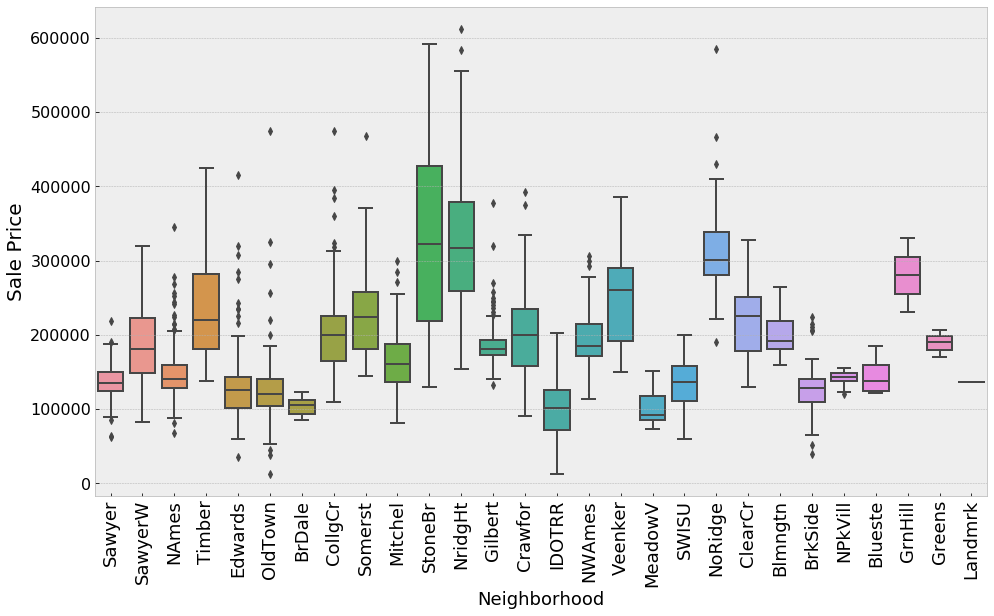

In [56]:
plt.figure(figsize=(16,9))
sns.boxplot(x='neighborhood', y='saleprice', data=df)
plt.yticks(fontsize = 16)
plt.ylabel('Sale Price', fontsize= 20)
plt.xlabel('Neighborhood',fontsize = 18)
plt.xticks(rotation=90, fontsize=18);

### Kitchen Quality has an interesting relationship to price:

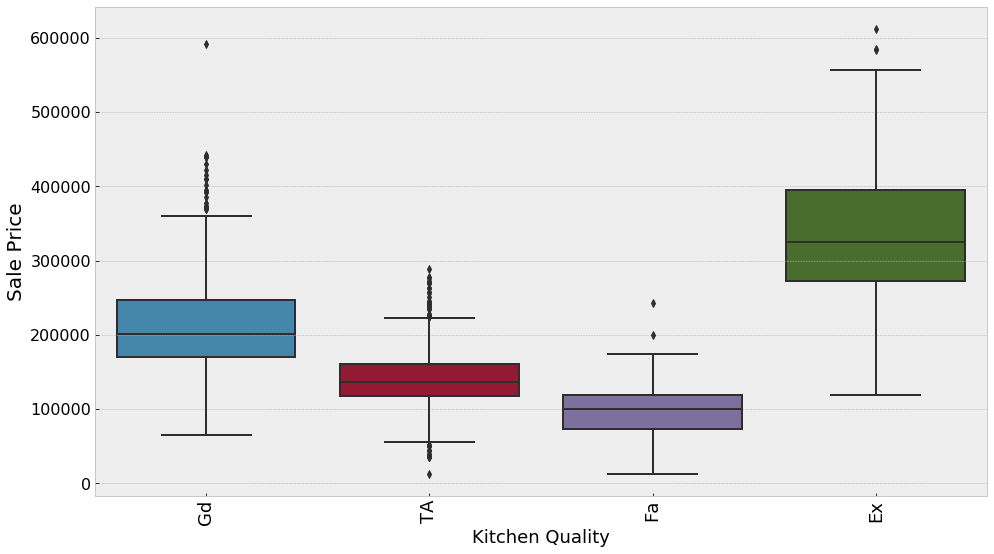

In [57]:
plt.figure(figsize=(16,9))
sns.boxplot(x='kitchen_quality', y='saleprice', data=df)
plt.yticks(fontsize = 16)
plt.ylabel('Sale Price', fontsize= 20)
plt.xlabel('Kitchen Quality',fontsize = 18)
plt.xticks(rotation=90, fontsize=18);

TypeError: can only concatenate str (not "float") to str

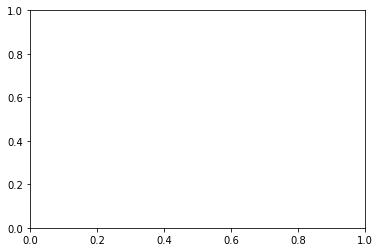

In [20]:
plt.boxplot(df[category_cols])


In [21]:
df[category_cols].info()
df[category_cols]=df[category_cols].fillnull('NA')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 42 columns):
ms_zoning          2051 non-null object
street             2051 non-null object
alley              140 non-null object
lot_shape          2051 non-null object
land_contour       2051 non-null object
utilities          2051 non-null object
lot_config         2051 non-null object
land_slope         2051 non-null object
neighborhood       2051 non-null object
condition_1        2051 non-null object
condition_2        2051 non-null object
bldg_type          2051 non-null object
house_style        2051 non-null object
roof_style         2051 non-null object
roof_matl          2051 non-null object
exterior_1st       2051 non-null object
exterior_2nd       2051 non-null object
mas_vnr_type       2029 non-null object
exter_quality      2051 non-null object
exter_cond         2051 non-null object
foundation         2051 non-null object
bsmt_quality       1996 non-null object
bsmt_cond     

AttributeError: 'DataFrame' object has no attribute 'fillnull'

/Users/allanshomefolder/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


TypeError: unhashable type: 'Index'

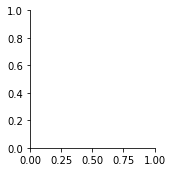

In [22]:
g = sns.FacetGrid(df, height=2.5)
g.map(sns.boxplot, category_cols, "saleprice", color="#334488", edgecolor="white", lw=.5);

g.fig.subplots_adjust(wspace=.02, hspace=.02, );

In [23]:
g = sns.FacetGrid(data=df, col_wrap=4, height=2)

g.map(sns.boxplot, df[col], df['saleprice']);

ValueError: num must be 1 <= num <= 0, not 1

<Figure size 576x0 with 0 Axes>

AttributeError: 'AxesSubplot' object has no attribute 'map'

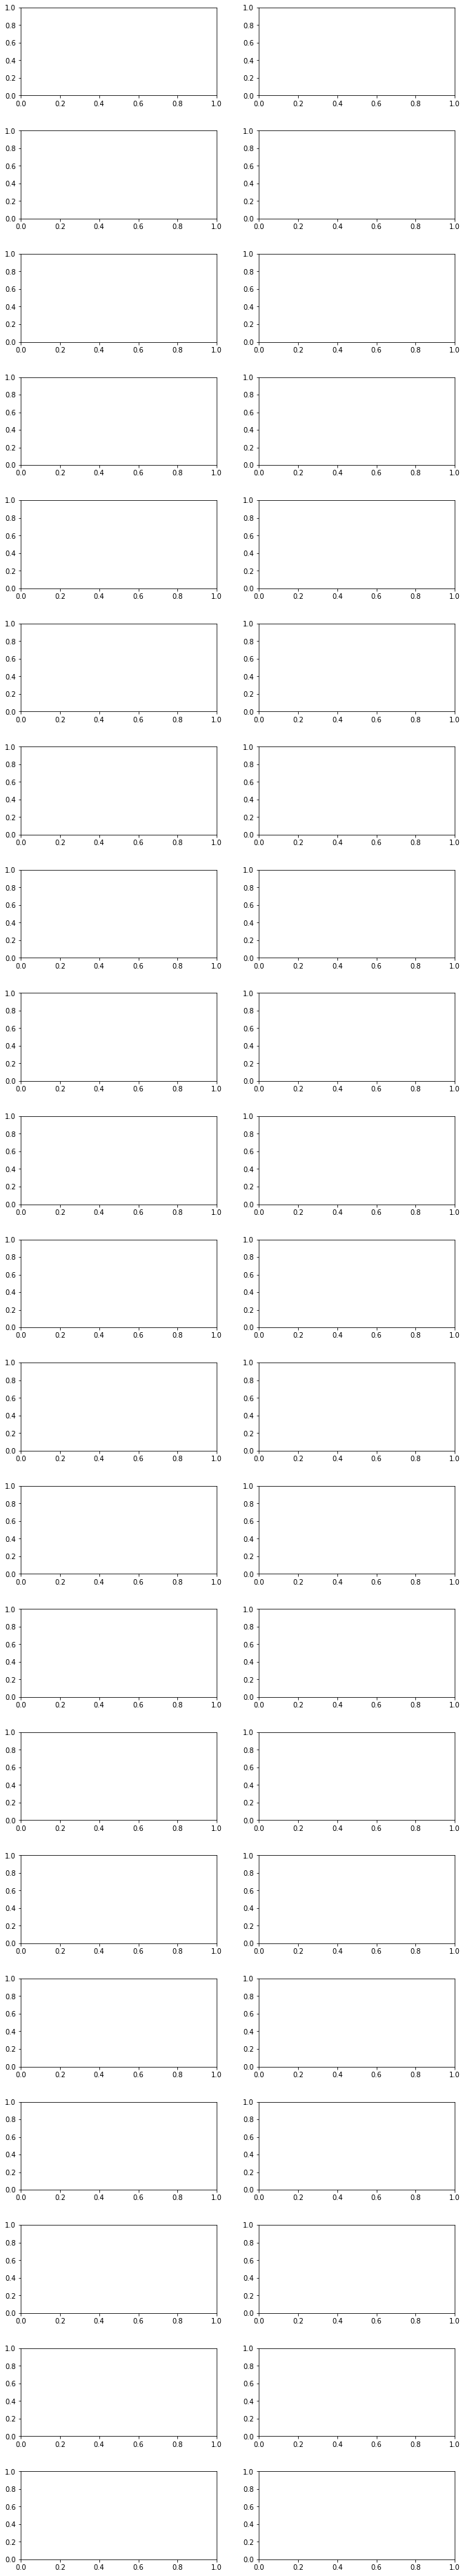

In [24]:
plt_boxplots(df, category_cols, 'saleprice' )

In [ ]:
from bokeh. import Box


In [ ]:
# Sub plot hist for many variables

def plt_hists(df, columns, ncols=2):
    nrows = int(np.ceil((len(columns))/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12, 2.5 * nrows))
    plt.style.use('bmh')
    plt.tight_layout(pad=3)
    ax = ax.ravel()
    for i, col in enumerate(columns):
        
        # Highly correlated features in red
        if abs(df['saleprice'].corr(df[col])) > 0.65:    
            color = 'darkred'
            alpha = 0.7
            ax[i].set_title(f'{col} has high correlation')
        else:
            color = 'black'
            alpha = 0.8
            ax[i].set_title(col)
        ax[i].hist(df[col], color=color, alpha=alpha)       # Plot histogram
        ax[i].set_ylabel('Frequency')
        ax[i].set_xlabel('')
        ax[i].axvline(df[col].mean(), color='red', linewidth=2)   # Mean line
        
# Some of this code was based on code from Cameron Bronstein

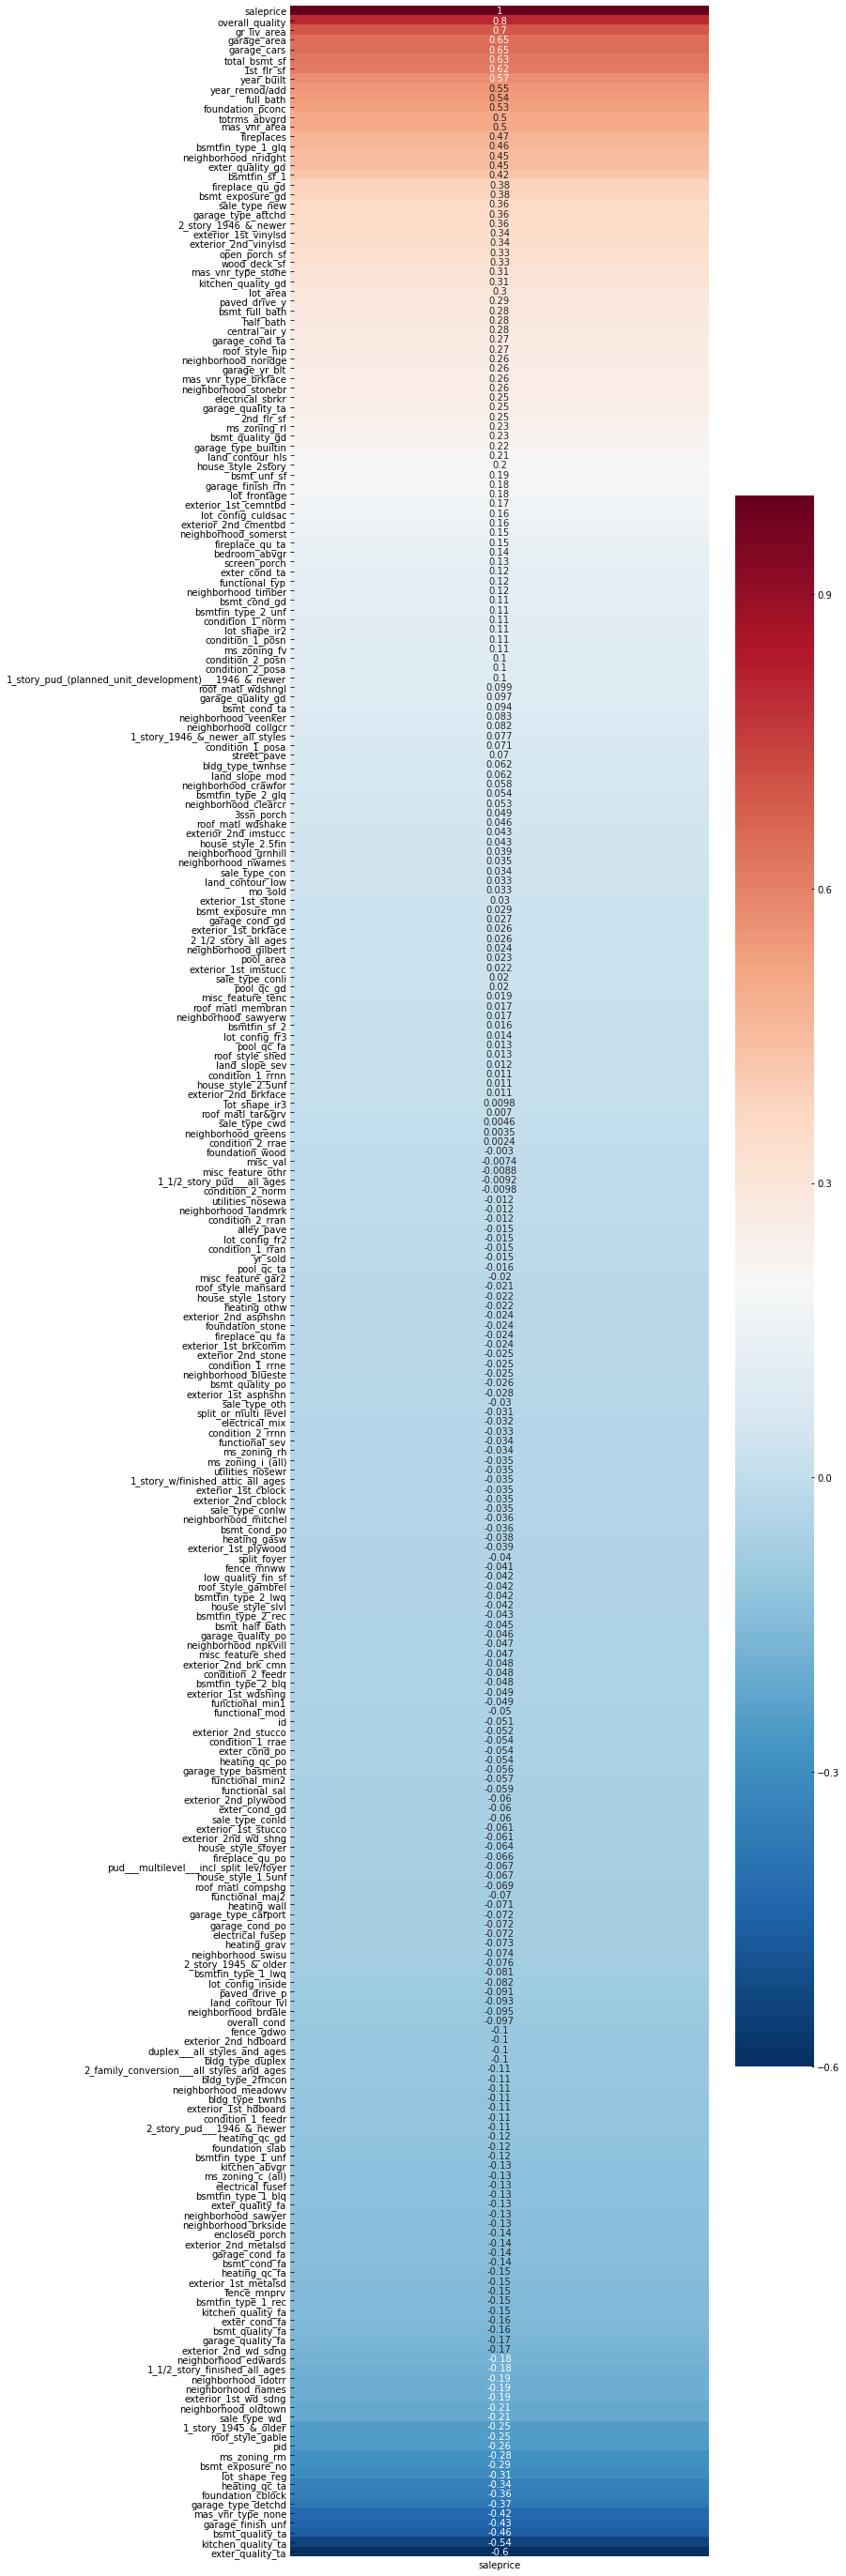

In [25]:
corr_rank(df_dummies, 'saleprice') 

#### Selecting highly correlated features to plot

In [26]:
features_Q=['exter_quality_ta','kitchen_quality_ta',
            'bsmt_quality_ta','garage_finish_unf',
            'mas_vnr_type_none','garage_type_detchd',
            'overall_quality','gr_liv_area',
            'garage_area','garage_cars',
            'total_bsmt_sf','1st_flr_sf',
            'year_built','year_remod/add',
            'full_bath','foundation_pconc',
            'totrms_abvgrd','mas_vnr_area'
            ]
X_Q= df_dummies[features_Q]
y= df_dummies['saleprice']

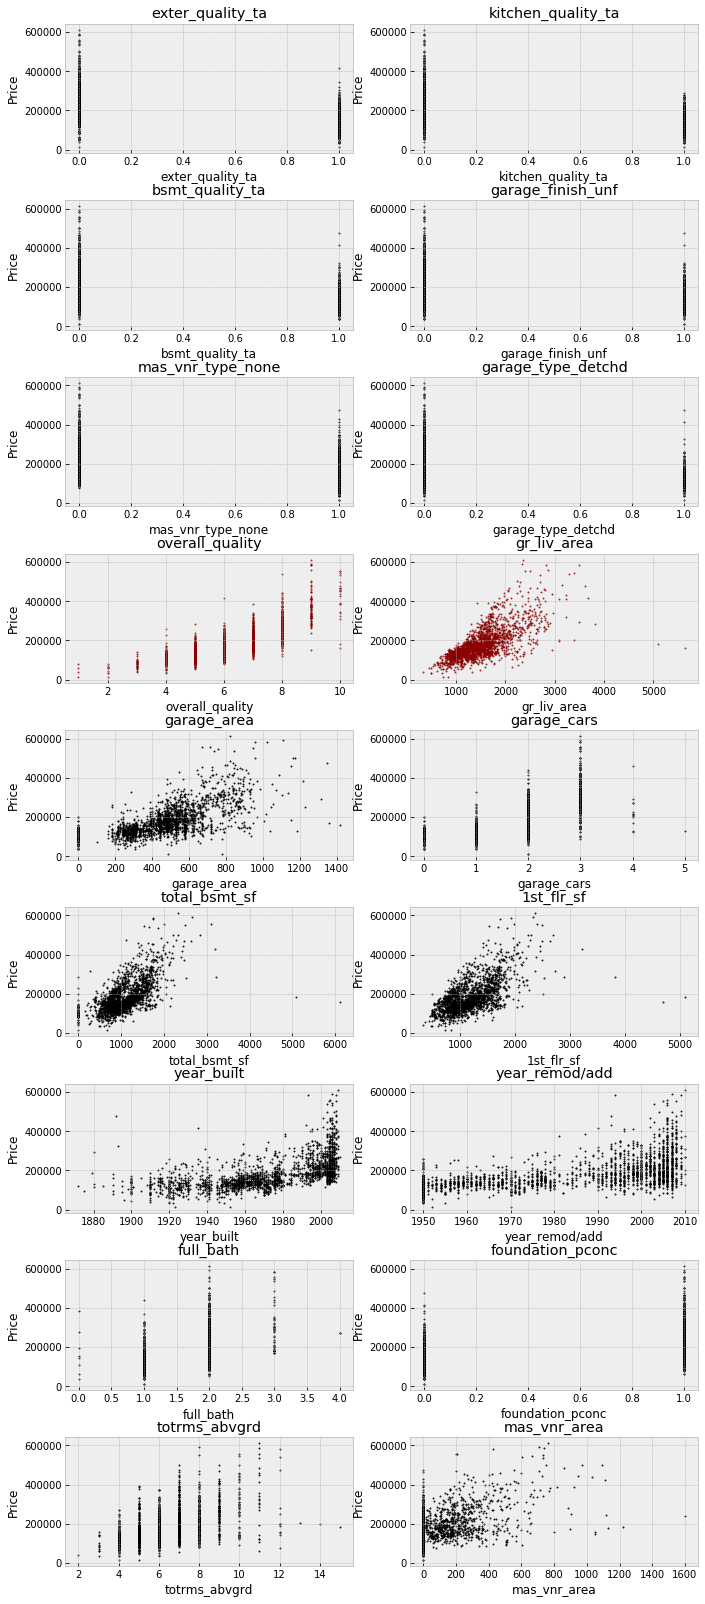

In [27]:
plt_subplots(df_dummies, features_Q, df_dummies['saleprice'])

In [48]:
# Identifying some outliers that could be skewing data.  

df_dummies.loc[df_dummies['gr_liv_area']> 4000]  #960 and 1885
df_dummies.loc[df_dummies['total_bsmt_sf']> 4000] # Same
df_dummies.loc[df_dummies['1st_flr_sf']> 3500] # same + 616
df_dummies.loc[df_dummies['mas_vnr_area']> 1200] # 1885 and 1409 (1600)

,id,pid,ms_subclass,lot_frontage,lot_area,overall_quality,overall_cond,year_built,year_remod/add,mas_vnr_area,...,pud___multilevel___incl_split_lev/foyer,split_foyer,split_or_multi_level,garage_area*garage_cars,ms_zoning_fv*neighborhood_somerst,gr_liv_area*totrms_abvgrd,2nd_flr_sf*house_style_2story,exterior_2nd_brk_cmn*neighborhood_npkvill,gr_liv_area*1st_flr_sf,kitchen_quality_ta*exterior_quality_ta
1409,1850,533241030,2-STORY 1946 & NEWER,66.0,7399,7,5,1997,1998,1600.0,...,0,0,0,1152.0,1,13650,975,0,1901250,0


In [29]:
# Dropping 2 outliers 
df_dummies.drop([960,1885], inplace=True)
if df_dummies.shape[0] == [2049]:
    print('Outliers successfully dropped.')

In [31]:
plot_hists(df_dummies, features_Q)

NameError: name 'plot_hists' is not defined

### Combine some related features into interaction features

In [32]:
pd.set_option('display.max_rows', 500)
hi_corr=df_dummies.corr().abs().unstack().sort_values(kind="quicksort", ascending=False)
hi_corr[hi_corr < 1].head() # Filtering out correlations of 1.0 

exterior_2nd_cmentbd                       exterior_1st_cemntbd                         0.988254
exterior_1st_cemntbd                       exterior_2nd_cmentbd                         0.988254
2_family_conversion___all_styles_and_ages  bldg_type_2fmcon                             0.977762
bldg_type_2fmcon                           2_family_conversion___all_styles_and_ages    0.977762
exterior_2nd_vinylsd                       exterior_1st_vinylsd                         0.977557
dtype: float64

In [33]:
# There are several features that seem to be dependent on eachother and could be combined into 
# interaction features.

def interaction_columns(df_dummies):
    """
    df_dummies = dataframe to manipulate, most likely the test df.
    
    """
    df_dummies['garage_area*garage_cars'] = df_dummies['garage_area'] * df_dummies['garage_cars']
    df_dummies['ms_zoning_fv*neighborhood_somerst'] = df_dummies['ms_zoning_fv'] * df_dummies['neighborhood_somerst']
    df_dummies['gr_liv_area*totrms_abvgrd'] = df_dummies['gr_liv_area'] * df_dummies['totrms_abvgrd']
    df_dummies['2nd_flr_sf*house_style_2story']=df_dummies['2nd_flr_sf']*df_dummies['house_style_2story']
    df_dummies['exterior_2nd_brk_cmn*neighborhood_npkvill']=df_dummies['exterior_2nd_brk_cmn']*df_dummies['neighborhood_npkvill']
    df_dummies['gr_liv_area*1st_flr_sf']=df_dummies['gr_liv_area']*df_dummies['1st_flr_sf']
    df_dummies['kitchen_quality_ta*exterior_quality_ta']=df_dummies['kitchen_quality_ta']*df_dummies['exter_quality_ta']
   
    

In [34]:
interaction_columns(df_dummies)
df_dummies.shape

(2049, 272)

### Saving clean dataset

In [35]:
df_dummies.to_csv('../datasets/df_dummies_clean.csv', index=False)

### Cleaning Test File

     Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0     NaN   
1   NaN       IR1          Lvl  ...          0            0         0     NaN   
2   NaN       IR1          Lvl  ...          0            0         0     NaN   
3   NaN       Reg          Lvl  ...          0            0         0     NaN   
4   NaN       IR1          Lvl  ...          0          185         0     NaN   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Typ

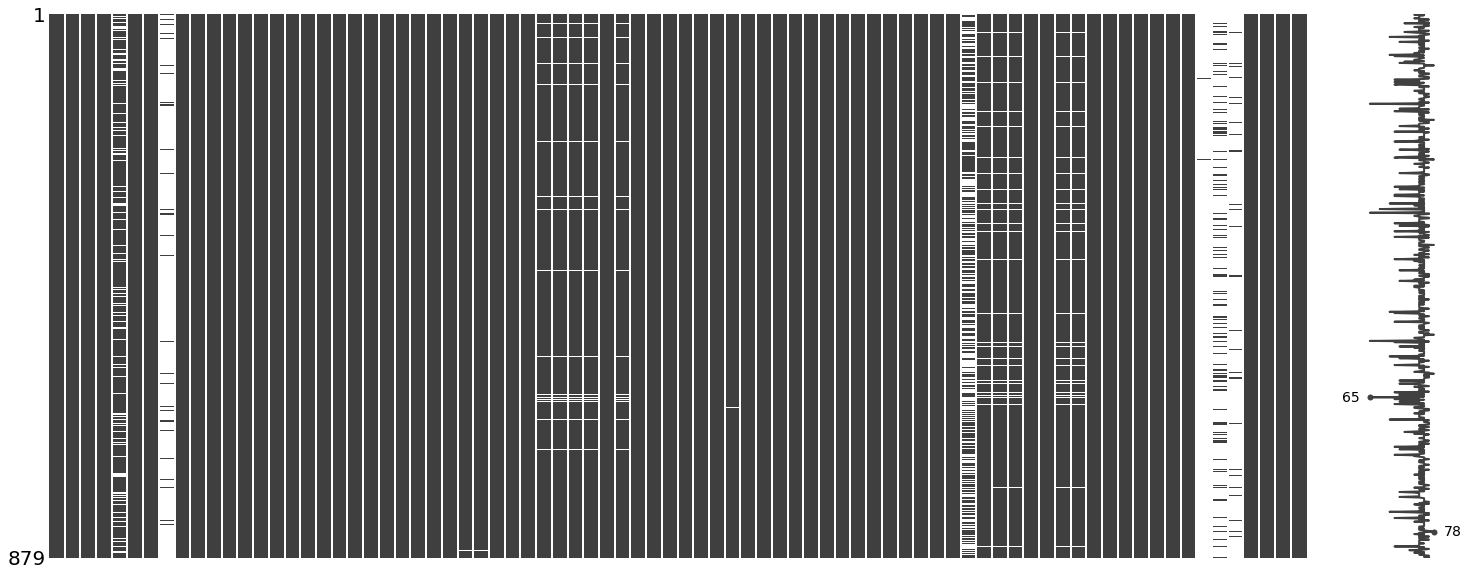

In [36]:
test=pd.read_csv('../datasets/test.csv')
check_data(test)

     id        pid  ms_subclass  lot_frontage  lot_area  overall_quality  \
0  2658  902301120          190          69.0      9142                6   
1  2718  905108090           90           NaN      9662                5   
2  2414  528218130           60          58.0     17104                7   
3  1989  902207150           30          60.0      8520                5   
4   625  535105100           20           NaN      9500                6   

   overall_cond  year_built  year_remod/add  mas_vnr_area  ...  garage_area  \
0             8        1910            1950           0.0  ...          440   
1             4        1977            1977           0.0  ...          580   
2             5        2006            2006           0.0  ...          426   
3             6        1923            2006           0.0  ...          480   
4             5        1963            1963         247.0  ...          514   

   wood_deck_sf  open_porch_sf  enclosed_porch  3ssn_porch  screen_p

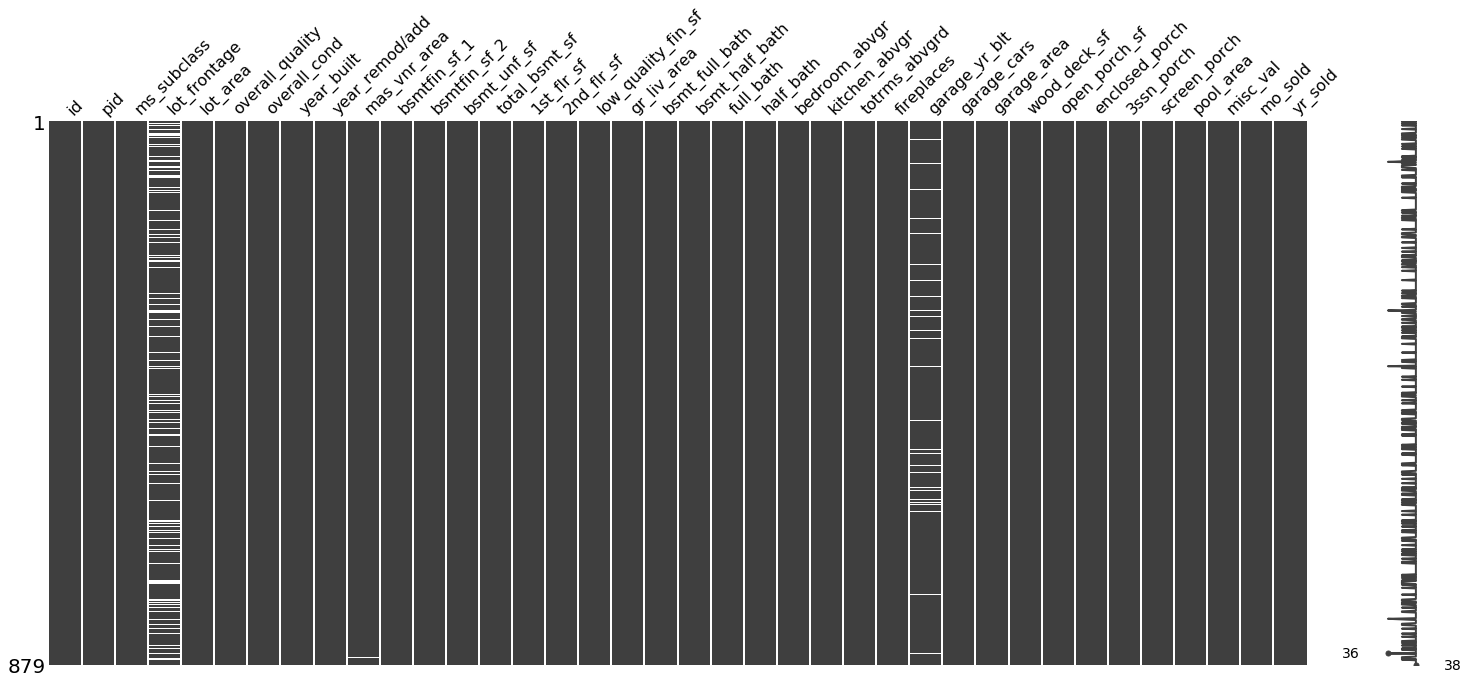

In [37]:
# Clean up Test dataset to match Train
snake_split(test)

# Seperate numeric and categorical columns
t_category_cols = test.select_dtypes(include=object).columns
t_num_cols = test.drop(category_cols, axis=1).columns
check_data(test[t_num_cols])
print(test.shape)

# Add dummies
test =pd.get_dummies(test,drop_first=True)
print(test.shape)
test.columns = test.columns.str.lower()
test['ms_subclass'] = test['ms_subclass'].apply(lambda x: ms_class_dummy[x]) # Get categorical values
ms_dummies = pd.get_dummies(test['ms_subclass'], drop_first=True)
test = pd.concat([test, ms_dummies], axis=1)
print(test.shape)
test.columns = test.columns.str.lower().str.replace('-','_').str.replace(' ','_')

# Add Interaction Columns
interaction_columns(test)
print(test.shape)

In [38]:
test[t_num_cols]=test[t_num_cols].fillna(0)
if df[num_cols].isnull().sum().sum() == 0:
    print('Null values in numeric columns have \nsuccessfully been replaced with zero.')

Null values in numeric columns have 
successfully been replaced with zero.


In [39]:
# Checking what the missing columns in the test set
missing_columns=list(set(df_dummies.columns).symmetric_difference(test.columns))

# Add missing columns
for col in missing_columns:
    test[col]=0
if test.shape[1] == df_dummies.shape[1]-1:
    print('Missing columns have successfully been added to test data.')

In [40]:
# saving clean test file
test.to_csv('../datasets/test_clean.csv', index=False)

### Exploring Numeric Features

There are some numeric columns that I can drop fromm my analysis.
- pid
- id
- bsmtfin_sf_2
- bsmt_unf_sf
- low_quality_fin_sf
- bsmt_full_bath
- bsmt_half_bath
- kitchen_abvgr
- 3ssn_porch
- screen_porch
- pool_area
- misc_val

In [144]:
features=num_cols.drop(['pid',
'id',
'bsmtfin_sf_2',
'bsmt_unf_sf',
'low_quality_fin_sf',
'bsmt_full_bath',
'bsmt_half_bath',
'kitchen_abvgr',
'3ssn_porch',
'screen_porch',
'pool_area',
'misc_val',
'saleprice'
])

In [141]:
X=df[features]
y=df['saleprice']

In [143]:
# Create a baseline score
lr = LinearRegression()
cross_val_score(lr,X, y, cv=5).mean()

0.8104234390198896

### Exploring polynomials of some of the numeric columns

In [150]:
# Trying polynomial features
poly = PolynomialFeatures(include_bias=False)
features_poly=['mo_sold',
              'open_porch_sf',
              'wood_deck_sf',
              'garage_area',
              'garage_cars',
              'fireplaces',
              'totrms_abvgrd',
              'bedroom_abvgr',
              'full_bath',
              'bsmt_full_bath',
              'gr_liv_area',
              '2nd_flr_sf',
              '1st_flr_sf',
              'bsmt_unf_sf',
              'overall_cond',
              'overall_quality']
X = df_dummies[features_poly]
X_poly = poly.fit_transform(X)
df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features_poly))
df_poly['saleprice']=df_dummies['saleprice']


In [152]:
lr=LinearRegression()
plot_vars(lr, df_dummies[features_poly], y)

TypeError: 'LinearRegression' object is not callable

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1a160e01e0> (for post_execute):


ValueError: Image size of 720x184500 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 720x184500 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x184500 with 2050 Axes>

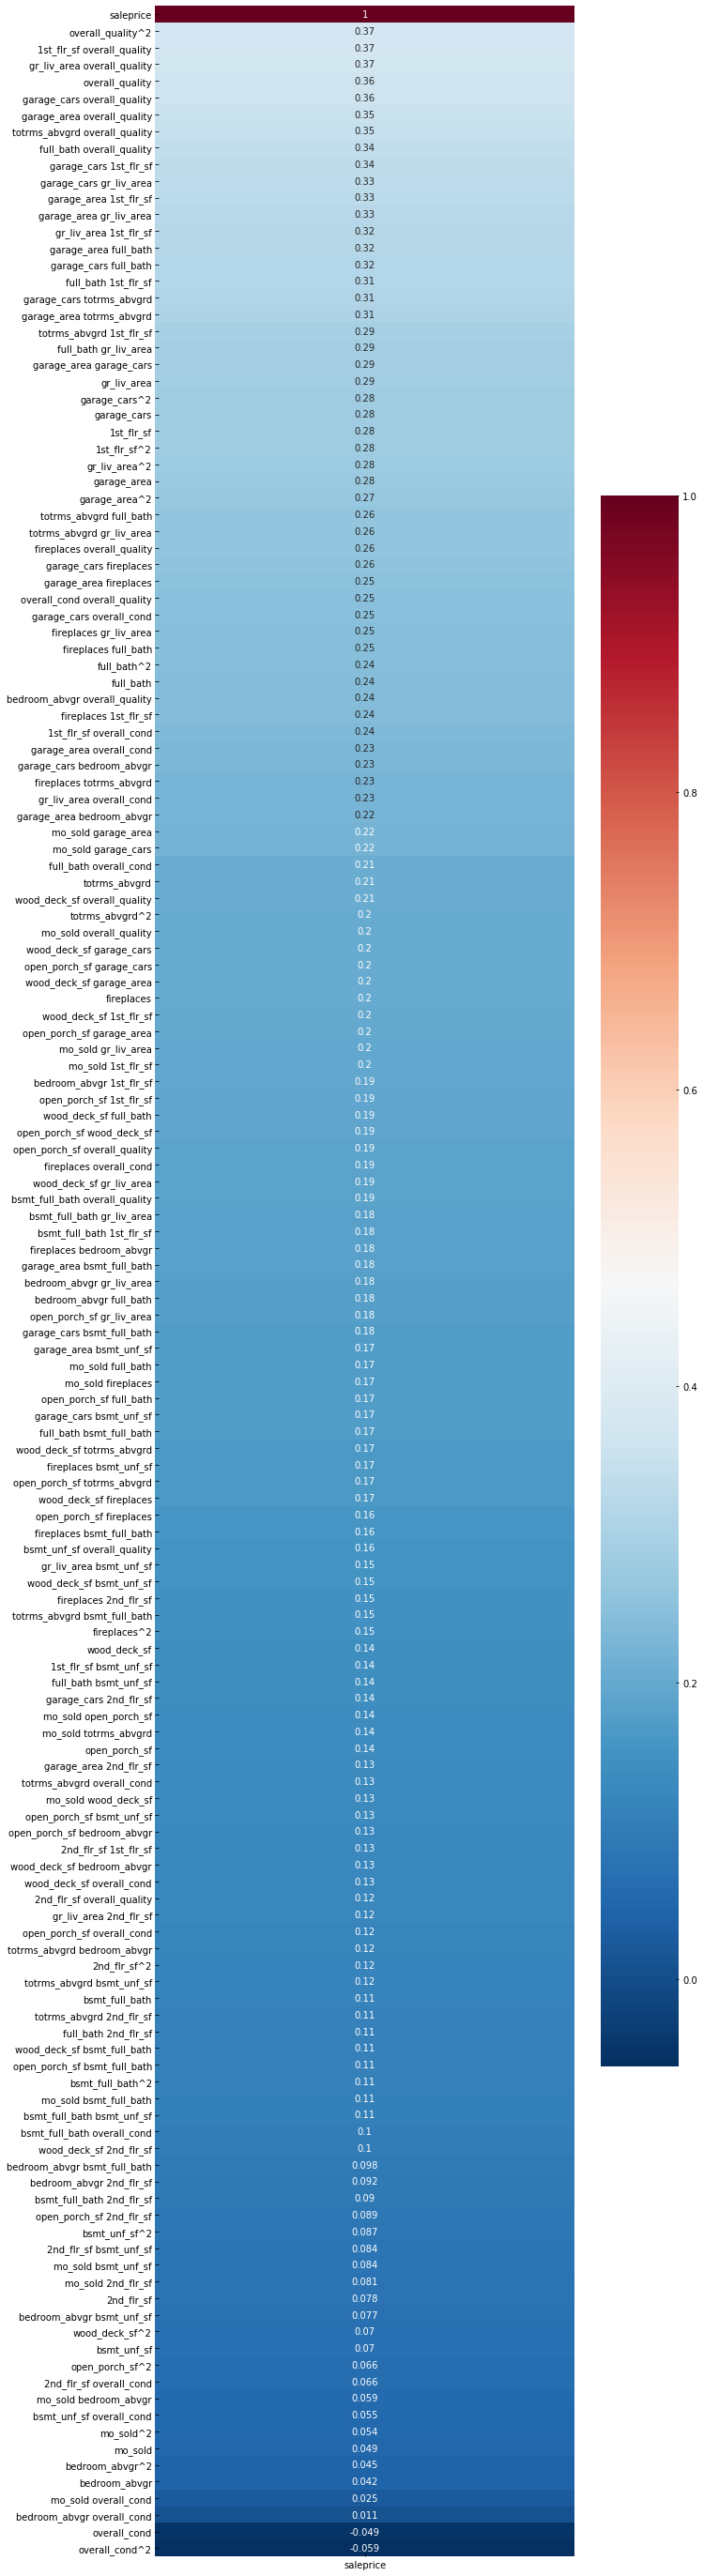

In [248]:
corr_rank(df_poly,'saleprice')